In [1]:
import os
import torch
import numpy as np
import torch.nn as nn
import muse.supplier as spr
import muse.processor as pcr
import muse.model2 as mdl
import muse.trainer as trn
import muse.visualizer as vis

import warnings
warnings.filterwarnings("ignore")

In [2]:
### ===== Hyperparameters ===== ###

mdl_name = 'dcgan'
instrument = 'Piano'
filepath = "./../input/haydn/"
song_len = 200*1
stride = 200
epochs = 1000
learning_rate = 0.001
batch_size = 1
latent_size = 20
device = trn.get_device()

In [3]:
### ===== Data Preprocessing ===== ###

seed_load = np.random.randint(0,999999999)
seed_load = 592643464 # set to seed that works
seed_model = np.random.randint(0,999999999)

all_midis, filenames = pcr.get_midis(filepath) # load all .midi files
Corpus, instru2corpus = pcr.extract_notes_batch(all_midis) # extract all notes and sort by instrument
Corpus = pcr.remove_rare(Corpus, 0)[0] # remove notes that occur for less than $thre$ times
Corpus, fmap, rmap = pcr.get_map(Corpus) # get forward-map and reverse-map from corpus
instru2corpus = pcr.remove_short(instru2corpus) # remove songs that are too short

X_train_melody, X_val_melody, X_train_offset, X_val_offset = pcr.train_test_split(instru2corpus, instrument, fmap, song_len, stride,\
                                                                                  seed=seed_load, process='center')
X_train_melody, X_val_melody = pcr.batchify(X_train_melody), pcr.batchify(X_val_melody) # reshape and turn into tensor
X_train_offset, X_val_offset = pcr.batchify(X_train_offset), pcr.batchify(X_val_offset) # reshape and turn into tensor

classes = len(set(Corpus)) # get number of unique keys

In [14]:
import torch.optim as optim

torch.manual_seed(653562540)
D = mdl.discriminator()
model = mdl.cnn_varautoencoder(1, song_len//200, classes)
G = trn.load_model('vae4_melody_CE', model, device)[0].decoder

D_solver = optim.Adam(D.parameters(), lr = 0.0001, betas = (0.5,0.999))
G_solver = optim.Adam(G.parameters(), lr = 0.001, betas = (0.5,0.999))

epoch_start = 0
epochs = 30
dtype = torch.FloatTensor
eepoch = 100
iter_count = 0
switch_count = 0
D_loss, G_loss = [], []
save = True
seeds = [seed_load, seed_model]

sample_latent = lambda batch_size, latent_size: torch.FloatTensor(batch_size, latent_size).uniform_(0, classes)
sample_noise = lambda shape: torch.FloatTensor(*shape).uniform_(-classes//10, classes//10)

def bce_loss(input, target):
    neg_abs = - input.abs()
    loss = input.clamp(min=0) - input * target + (1 + neg_abs.exp()).log()
    return loss.mean()

def discriminator_loss(logits_real, logits_fake, smooth=0.5, switch=False):
    N, _ = logits_real.size() 
    label_real_truth = smooth*torch.ones(N).type(dtype)
    label_fake_truth = torch.zeros(N).type(dtype)
    if not switch:
        label_real, label_fake = label_real_truth, label_fake_truth
    else:
        label_real, label_fake = label_fake_truth, label_real_truth
    loss = (bce_loss(logits_real, label_real))+(bce_loss(logits_fake, label_fake))
    return loss

def generator_loss(logits_fake):
    N, _ = logits_fake.size()
    loss = (bce_loss(logits_fake, torch.ones(N).type(dtype)))
    return loss

for epoch in range(epoch_start, epoch_start+epochs):
    for x in X_train_melody:
        D_solver.zero_grad()
        real = x.type(dtype)
        logits_real = D(real).type(dtype)
        
        latent = sample_latent(1, latent_size).type(dtype)
        fake = G(latent).detach()
        noise = sample_noise(fake.shape)
        fake += noise
        logits_fake = D(fake)
        
        d_error = discriminator_loss(logits_real, logits_fake, switch=False)
        
        if d_error.item() > 0.9:
            d_error.backward()        
            D_solver.step()
        
        G_solver.zero_grad()
        latent = sample_latent(1, latent_size).type(dtype)
        fake = G(latent)
        logits_fake_G = D(fake)
        
        g_error = generator_loss(logits_fake_G)
        g_error.backward()
        G_solver.step()
        
        if iter_count%eepoch == 0:
            print('Iter: {}, D: {:.4}, G:{:.4}'.format(iter_count,d_error.item(),g_error.item()))
        iter_count += 1
        
        D_loss.append(d_error.item())
        G_loss.append(g_error.item())
        
    # save model
    if save:
        state = {'epoch': epoch, 'state_dict_D': D.state_dict(), 'state_dict_G': G.state_dict(),
        'D_loss': D_loss, 'G_loss':G_loss, 'seeds': seeds}
        torch.save(state, './models/'+mdl_name+'.pt')

Iter: 0, D: 1.055, G:0.0
Iter: 100, D: 0.7838, G:3.842
Iter: 200, D: 0.8937, G:2.905
Iter: 300, D: 1.665, G:13.02
Iter: 400, D: 4.683, G:56.36
Iter: 500, D: 0.8224, G:5.414
Iter: 600, D: 0.813, G:3.26
Iter: 700, D: 0.8726, G:2.425
Iter: 800, D: 0.9646, G:2.51
Iter: 900, D: 0.9866, G:2.812
Iter: 1000, D: 0.8668, G:1.897
Iter: 1100, D: 0.8858, G:1.666
Iter: 1200, D: 1.064, G:2.365
Iter: 1300, D: 0.9806, G:1.17
Iter: 1400, D: 1.071, G:1.376
Iter: 1500, D: 1.084, G:0.764
Iter: 1600, D: 0.8732, G:2.07
Iter: 1700, D: 1.104, G:1.16
Iter: 1800, D: 1.2, G:1.208
Iter: 1900, D: 1.007, G:1.209
Iter: 2000, D: 1.171, G:1.349
Iter: 2100, D: 1.036, G:0.7241
Iter: 2200, D: 1.125, G:0.8571
Iter: 2300, D: 0.9258, G:0.8131
Iter: 2400, D: 0.9801, G:0.4444
Iter: 2500, D: 0.9041, G:3.455
Iter: 2600, D: 0.9758, G:0.8333
Iter: 2700, D: 0.9953, G:0.554


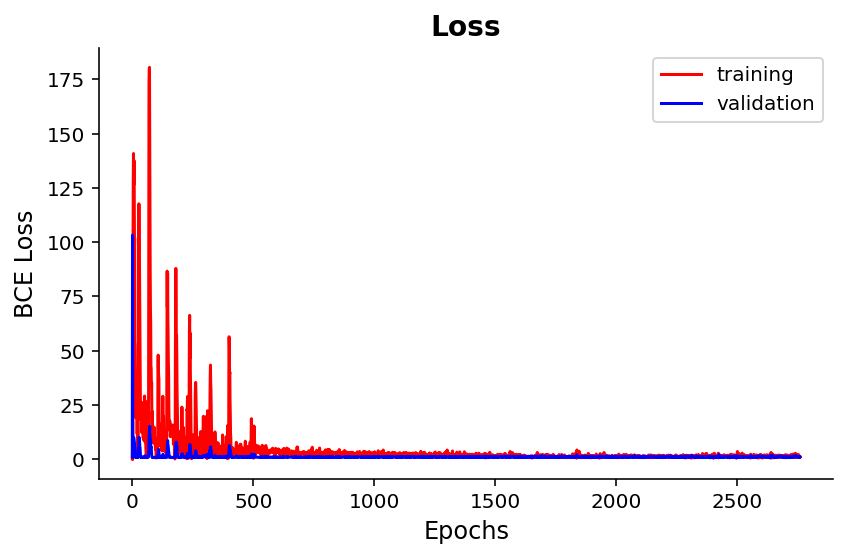

<Figure size 432x288 with 0 Axes>

In [15]:
vis.plot_train_val_loss(G_loss, D_loss, './figures/dcgan_vae4_melody.png', ylabel='BCE Loss', save=True, blank=False, figsize=(6,4))
# labels=['Discriminator loss', 'Generator loss']

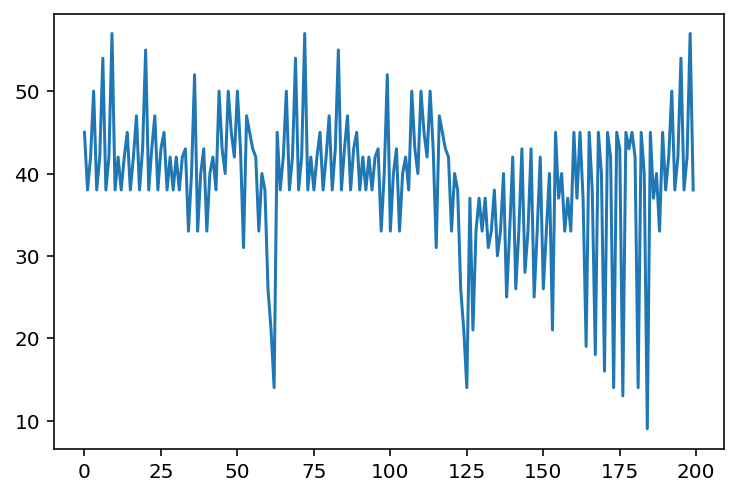

In [16]:
import matplotlib.pyplot as plt
idx = np.random.randint(0, len(X_train_melody))
plt.plot(X_train_melody[idx].view(-1).detach().numpy())
np.save('models/real.npy', X_train_melody[idx].view(-1).detach().numpy())

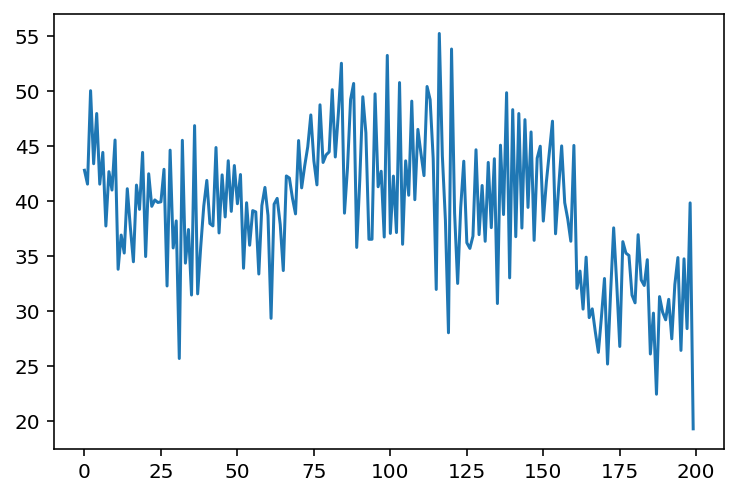

In [17]:
import matplotlib.pyplot as plt
plt.plot(fake.view(-1).detach().numpy())
np.save('models/fake_load.npy', fake.view(-1).detach().numpy())

tensor([[32.6118, 57.1915, 38.8983, 20.7213, 31.2662, 25.3779,  2.1196,  8.2347,
          4.0521, 33.6204, 26.0765, 42.4151,  6.2269, 38.0148, 40.9825, 18.7216,
         41.0327, 24.6297, 53.2613, 49.8736]])


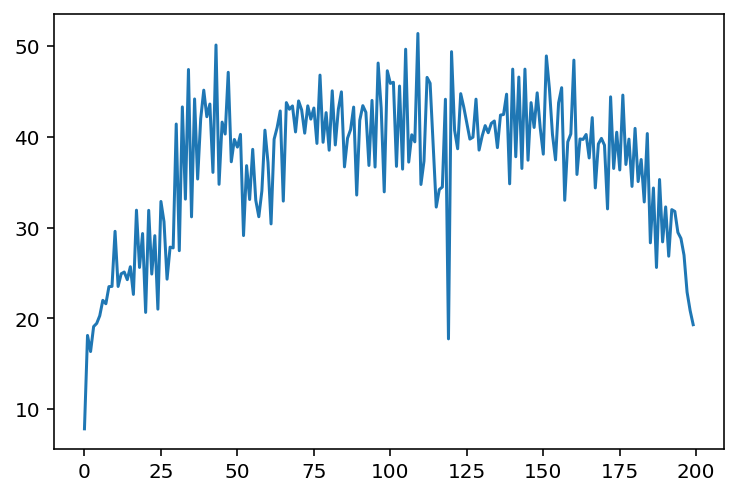

In [53]:
G.eval()
latent = sample_latent(1, latent_size).type(dtype)
print(latent)
fake2 = G(latent)

plt.plot(fake2.view(-1).detach().numpy())